In [ ]:
# GNU LESSER GENERAL PUBLIC LICENSE
#                       Version 3, 29 June 2007
# Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>
# Everyone is permitted to copy and distribute verbatim copies
# of this license document, but changing it is not allowed.

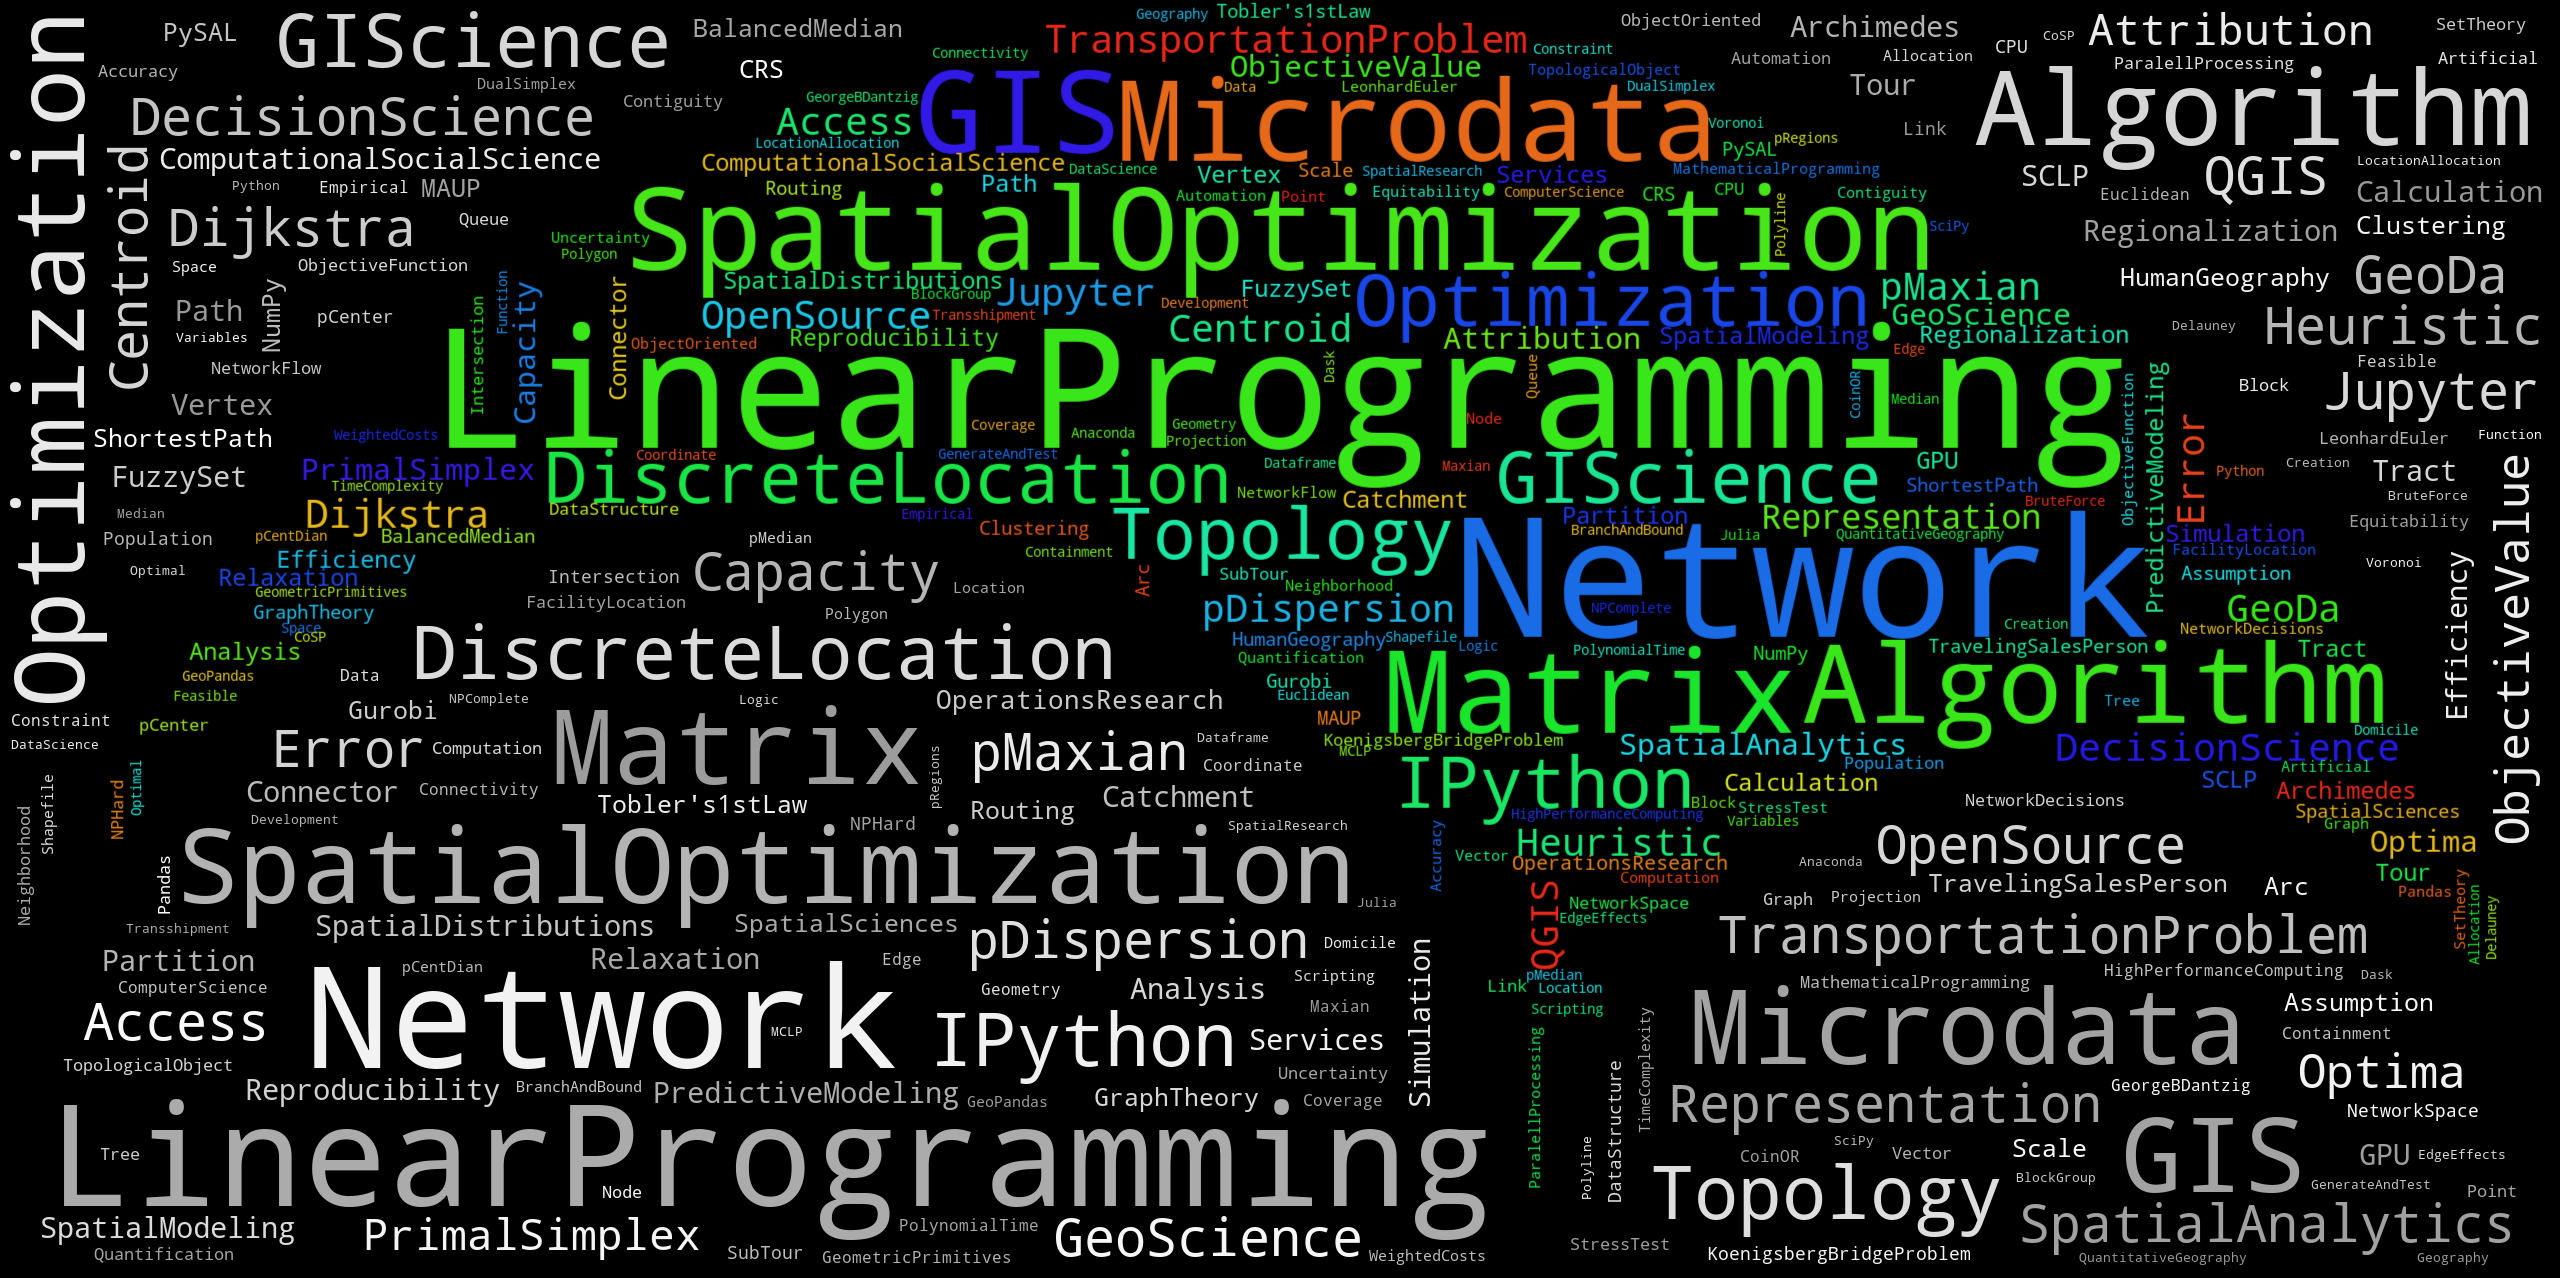

In [9]:
import IPython.display as IPd
import os
path = os.path.dirname(".")
graphics_path = path + "Graphics/"
data_path =  path + "Data/"
session = IPd.Image(graphics_path+"/arbelos_keywords_logo.png", width=1000, height=600)
session

# $$\text{Automated GISci for Network-based Decisions}$$
# $$\text{Association of American Geographers}$$
## $$\text{Boston 2017}$$

## $$\text{An Out-of-Core Computational Approach to the Transportation Problem}$$


## $$ \begin{array}{ll}
\text{James D. Gaboardi}  & \text{Florida State University}\\
\end{array}
$$

The Transportation Problem, which is also known as the Transportation Simplex or the 
Transshipment Problem, seeks to allocate supply to demand while minimizing transportation
costs and was formally described by Hitchcock (1941). Supply ($n$) and demand ($m$) are
generally represented as unit weights of decision variables at facilities along a network with
the time or distance between nodes representing the cost of transporting one unit from a
supply node to a demand node. These costs are stored in an $n$ x $m$ cost matrix. The
Transportation Problem has continued to garner attention through to the present in multiple
academic disciplines with Spatial Optimization in Geography being one of these at the
forefront. As the processing power of computers has improved over the years, the capabilities
of mathematical programming software to solve these problems have also improved.
However, one of the main roadblocks is the need to store the ever-larger cost and decision
variable matrices in memory while building and solving the optimization model. This paper
seeks to provide a solution to the issue, not by modifying the structure of the problem or
proposing a new algorithm, but by tackling the memory bottleneck with out-of-core storage.
This will be attempted in an object-oriented programming language environment primarily
utilizing two Python packages: dask (a parallel computing library) and pulp (an integer and
mixed-integer programing library).

* plan
    * intro to the trans prob
    * formulations
        * balanced
        * unbalanced
    * small purely simulated example
    * chart of 
    * larger waverly example
    * Bigger example kiddo

* # $Gurobi$ Notes
    * ## Parameters
        * ### documentation/current/parameters.html
        * #### `model.Params.TimeLimit("60")` --> for 60 seconds
        * #### `setParam("TimeLimit", 60)` --> for 60 seconds
    * ## Create and display in `html`
    * ## $Gurobi$ Spider Plot example??
    * ### `disposeDefaultEnv()`

## $\text{The Transportation Problem: Balanced Integer Programming Formulation}$

---

### $\text{Primal: minimize the cost needed to ship units from supply facilities to demand facilities.}$
---

## $$ \begin{array}{rll}
 \text{min}  & \displaystyle \sum_{i \in I} \sum_{j \in J} c_{ij} sd_{ij}&         \\
 \text{s.t.} & \displaystyle \sum_{j \in J} sd_{ij} = S_i        & \forall i \in I \\
             & \displaystyle \sum_{i \in I} sd_{ij} = D_j        & \forall j \in J \\
             & \displaystyle sd_{ij} \geq 0     & \forall i \in I, \forall j \in J \\
\end{array}
$$

### $$ \begin{array}{rl}
 \text{where}&\\
             & \scriptsize{i = \text{a specific origin}} \\
             & \scriptsize{j = \text{a specific destination}} \\
             & \scriptsize{I = \text{the set of origins}} \\
             & \scriptsize{J = \text{the set of destinations}} \\
             & \scriptsize{a_{i} = \text{demand weight at each node}} \\
             & \scriptsize{c_{ij} = \text{travel costs between nodes}} \\
             & \scriptsize{sd_{ij} = \text{shipping decision variable from } i \text{ to } j} \\
             & \scriptsize{S_{i} = \text{units of supply from facility } i} \\
             & \scriptsize{D_{j} = \text{units of demand by facility } j} \\
\end{array}
$$

-----

Originally published:
- ***Hitchcock, Frank L. 1941***. The Distribution of a Product from Several Sources to Numerous Localities. *Journal of Mathematics and Physics*. 20(1):224-230.

Adapted from:
- ***Daskin, Mark. S. 1995***. Network and Discrete Location: Models, Algorithms, and Applications. Hoboken, NJ, USA: John Wiley & Sons, Inc.

---

### Our goal is to be able to:

1. Solve a Balanced 50,000 x 50,000 Transportation Problem with simulated data;
2. Solve a network-based Balanced 50,000 x 50,000 Transportation Problem with simulated data;
3. Solve a network-based very large Transportation Problem with empircal data (potentially Atlanta,GA)

#### Ideally, this will all be done without altering the structure of the Transportation Problem by utilizing other `python` packages like `dask`, `numba`, etc.

-----

# $\text{Import Pacakges and Declare Constants}$

In [26]:
import geopandas as gpd
import pysal as ps
import dask.array as da
import gurobi as grb
import numpy as np
import pandas as pd
import psutil
import platform
import sys
import time
from collections import OrderedDict
#%load_ext memory_profiler
#%load_ext snakeviz

GB = 1073741824.0005517
operators = {"==": operator.eq, "<=": operator.le, ">=": operator.ge}

In [29]:
def transportation_simplex(r_dim, c_dim, seed=1, balanced=True, simulated_costmatrix=[1,10],
                           simulated_supply=None, simulated_demand=None, write_lp=True, name=None):
    def _get_supply_constrs(m, oper="=="):
        operator = operators[oper]
        m.addConstrs((operator(decision_variables.sum(origin,'*')\
                                   - supply[origin], 0)\
                                   for origin in row_range),
                                   "Supply")
        return m 
    def _get_demand_constrs(m, oper="==")::
        m.addConstrs((operator(decision_variables.sum('*',destination)\
                                              - demand[destination], 0)\
                                           for destination in column_range),
                                           "Demand")
    
    
    
    np.random.seed(seed)
    scaling_metric = r_dim/float(c_dim)
    row_range, column_range = range(r_dim), range(c_dim)
    if simulated_costmatrix:
        cm = np.random.randint(simulated_costmatrix[0],
                               simulated_costmatrix[1],
                               (r_dim,c_dim)).astype(float)
    if simulated_supply:
        scaled_supply = [int(val*scaling_metric) for val in simulated_supply]
        supply = np.random.randint(scaled_supply[0],
                                   scaled_supply[1],
                                   (r_dim,1)).astype(float)
    if balanced:
        equal_sum = False
        while equal_sum == False:
            scaled_demand = [int(val*scaling_metric) for val in simulated_demand]
            demand = np.random.randint(scaled_demand[0],
                                       scaled_demand[1],
                                       (c_dim,1)).astype(float)
            if demand.sum() == supply.sum():
                equal_sum = True
    var_names = pd.DataFrame(np.array(["sd["+str(r)+","+str(c)+"]"\
                                   for r in row_range\
                                   for c in column_range]).reshape(r_dim,c_dim),
                                   index=['s'+str(r) for r in row_range],
                                   columns=['d'+str(c) for c in column_range])
    transportation_simplex = grb.Model(name)
    #grb.setParam('MIPFocus', 2)
    #transportation_simplex.Params.method = 1
    #grb.setParam('TimeLimit', 10)
    #transportation_simplex.setParam('TimeLimit', 1)
    #transportation_simplex.Params.TimeLimit("10")
    decision_variables = transportation_simplex.addVars(r_dim,
                                                        c_dim,
                                                        vtype=grb.GRB.CONTINUOUS,
                                                        obj=cm,
                                                        name="sd")
    _get_supply_constrs(transportation_simplex)
    _get_demand_constrs(transportation_simplex)
    
    
    transportation_simplex.addConstrs((decision_variables.sum('*',destination)\
                                           - demand[destination] == 0\
                                           for destination in column_range),
                                           "Demand")
    transportation_simplex.setObjective(grb.quicksum(decision_variables[origin,destination].Obj\
                                    * decision_variables[origin,destination] 
                                    for origin in row_range 
                                    for destination in column_range))
    transportation_simplex.optimize()
    
    if write_lp:
        transportation_simplex.write(name+".lp")
    decisions = pd.DataFrame([[var.VarName, var.X]\
                               for var in transportation_simplex.getVars()\
                               if var.X > 0], columns=['Decision_Variable_Name', 'Decision_Variable_Value'])
    return decisions, cm

# $5,3 \text{ cost matrix}$

In [30]:
solution_variables, cost_matix = transportation_simplex(5,
                                                        3,
                                                        seed=2,
                                                        simulated_costmatrix=[1,10],
                                                        simulated_supply=[10,20],
                                                        simulated_demand=[10,50],
                                                        name="TransportationProblem")
cm_size = sys.getsizeof(cost_matix)/GB
print "***************************************************"
print "Cost Matrix size (GB):\t\t", cm_size
print "***************************************************"
solution_variables.head()

Optimize a model with 8 rows, 15 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 7e+01]
Presolve time: 0.01s
Presolved: 8 rows, 15 columns, 30 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7500000e+02   5.000000e+01   0.000000e+00      0s
       2    5.0700000e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.03 seconds
Optimal objective  5.070000000e+02
***************************************************
Cost Matrix size (GB):		2.16066837311e-07
***************************************************


/Users/jgaboardi/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


,Decision_Variable_Name,Decision_Variable_Value
0,"sd[0,2]",20.0
1,"sd[1,0]",26.0
2,"sd[2,0]",25.0
3,"sd[2,1]",2.0
4,"sd[3,0]",16.0


# $50,30 \text{ cost matrix}$

In [24]:
solution_variables, cost_matix = transportation_simplex(50,
                                                        30,
                                                        seed=2,
                                                        simulated_costmatrix=[1,10],
                                                        simulated_supply=[10,20],
                                                        simulated_demand=[10,50],
                                                        name="TransportationProblem")
cm_size = sys.getsizeof(cost_matix)/GB
print "***************************************************"
print "Cost Matrix size (GB):\t\t", cm_size
print "***************************************************"
solution_variables.head()

Optimize a model with 80 rows, 1500 columns and 3000 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 8e+01]
Presolve time: 0.01s
Presolved: 80 rows, 1500 columns, 3000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2720000e+03   8.550000e+02   0.000000e+00      0s
      58    1.3060000e+03   0.000000e+00   0.000000e+00      0s

Solved in 58 iterations and 0.04 seconds
Optimal objective  1.306000000e+03
***************************************************
Cost Matrix size (GB):		1.12801790237e-05
***************************************************


/Users/jgaboardi/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:37: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


,Decision_Variable_Name,Decision_Variable_Value
0,"sd[0,27]",31.0
1,"sd[1,13]",29.0
2,"sd[2,16]",8.0
3,"sd[2,27]",20.0
4,"sd[3,6]",17.0


# $500,300 \text{ cost matrix}$

In [ ]:
solution_variables, cost_matix = transportation_simplex(500,
                                                        300,
                                                        seed=2,
                                                        simulated_costmatrix=[1,10],
                                                        simulated_supply=[10,20],
                                                        simulated_demand=[10,50],
                                                        name="TransportationProblem")
cm_size = sys.getsizeof(cost_matix)/GB
print "***************************************************"
print "Cost Matrix size (GB):\t\t", cm_size
print "***************************************************"
solution_variables.head()

In [2]:
import operator

In [3]:
print dir(operator)


['__abs__', '__add__', '__and__', '__concat__', '__contains__', '__delitem__', '__delslice__', '__div__', '__doc__', '__eq__', '__file__', '__floordiv__', '__ge__', '__getitem__', '__getslice__', '__gt__', '__iadd__', '__iand__', '__iconcat__', '__idiv__', '__ifloordiv__', '__ilshift__', '__imod__', '__imul__', '__index__', '__inv__', '__invert__', '__ior__', '__ipow__', '__irepeat__', '__irshift__', '__isub__', '__itruediv__', '__ixor__', '__le__', '__lshift__', '__lt__', '__mod__', '__mul__', '__name__', '__ne__', '__neg__', '__not__', '__or__', '__package__', '__pos__', '__pow__', '__repeat__', '__rshift__', '__setitem__', '__setslice__', '__sub__', '__truediv__', '__xor__', '_compare_digest', 'abs', 'add', 'and_', 'attrgetter', 'concat', 'contains', 'countOf', 'delitem', 'delslice', 'div', 'eq', 'floordiv', 'ge', 'getitem', 'getslice', 'gt', 'iadd', 'iand', 'iconcat', 'idiv', 'ifloordiv', 'ilshift', 'imod', 'imul', 'index', 'indexOf', 'inv', 'invert', 'ior', 'ipow', 'irepeat', 'irs

In [9]:
operator.is_(1,2)

False

# $ \text{ Empirical Network Subset}$

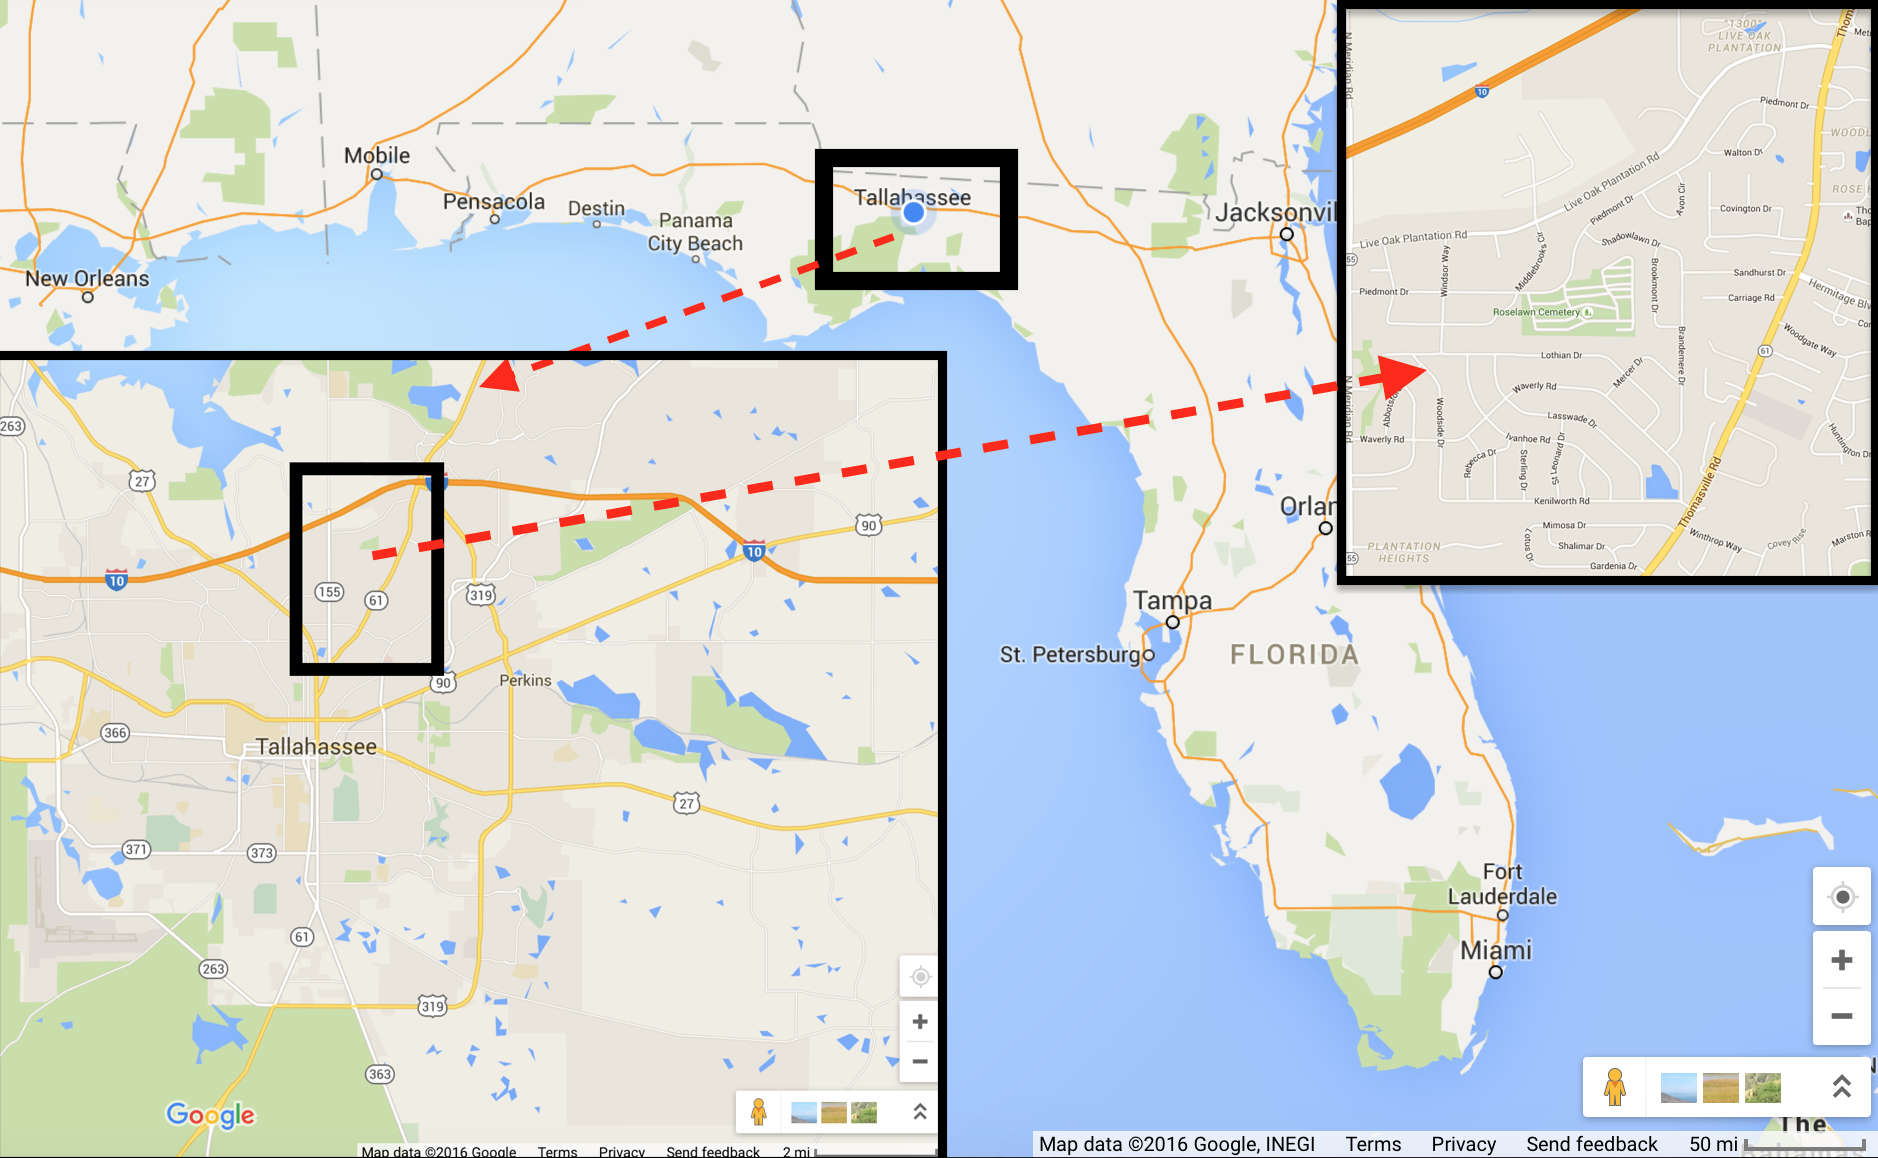

In [12]:
#FLTallWav
FLTallWav = IPd.Image(graphics_path+"/FLTallWav.png", width=1200, height=600)
FLTallWav

In [ ]:
ntw = ps.Network(path+'WAVERLY/WAVERLY.shp')
shp_W = ps.open(path+'WAVERLY/WAVERLY.shp')
buff = STREETS.buffer(200)  #Buffer
buff[:5]

In [ ]:
buff.plot()

In [ ]:
buffU = buff.unary_union  #Buffer Union
buff1 = gpd.GeoSeries(buffU)
buff1.crs = STREETS.crs
Buff = gpd.GeoDataFrame(buff1, crs=STREETS.crs)
Buff.columns = ['geometry']
Buff

In [ ]:
Buff.plot()

In [ ]:
np.random.seed(352)
x = np.random.uniform(shp_W.bbox[0], shp_W.bbox[2], 1000)
np.random.seed(850)
y = np.random.uniform(shp_W.bbox[1], shp_W.bbox[3], 1000)  
coords0= zip(x,y)
coords = [shapely.geometry.Point(i) for i in coords0]
Rand = gpd.GeoDataFrame(coords)
Rand.crs = STREETS.crs
Rand.columns = ['geometry']
Rand[:5]

In [ ]:
Rand.plot()

In [ ]:
Inter = [Buff['geometry'].intersection(p) for p in Rand['geometry']]
INTER = gpd.GeoDataFrame(Inter, crs=STREETS.crs)
INTER.columns = ['geometry']
INTER[:5]

In [ ]:
INTER.plot()

### Define the Function to Solve the Transportation Problem

In [2]:
def gurobiTransportationSimplex(m,
                                cij, 
                                si, 
                                dj,
                                selected,
                                output=False,
                                print_results=False,
                                verbose=False,
                                lp_write=False,
                                write_path=None):
    """
    Solve a balanced Transportation Simplex in Gurobi
    
    Parameters
    ==========
    m:              gurobi.Model
                    Instantiated Gurobi model
                    
    cij:            numpy.ndarray
                    Vector of transportation costs consisting of 
                    [(n) rows by (m) columns] elements.
                    
    si:             numpy.ndarray
                    Vector of supply units (s) consisting of 
                    [(n) rows] elements.
                    
    dj:             numpy.ndarray
                    Vector of demand units (d) consisting of 
                    [(m) columns] elements.
                    
    selected:       collections.OrderedDict
                    An empty OrderedDict used to store selected
                    supply_demand locations and quantity of units
                    shipped.
                    
    output:         bool (default is False).
                    Print out solution progress (True).
    
    print_results:  bool (default is False)
                    Print out solution diagnostics (True).
                    
    verbose:        bool (default is False)
                    Print out supply/demand allocation decisions (True).
                    
    lp_write:       bool (default is False)
                    Write out a linear programming file (True) in 
                    IBM Cplex format.
          
    write_path:     str (optional)
                    Directory PATH and file name.

    Returns
    =======
    selected:       collections.OrderedDict
                    The populated OrderedDict of store selected
                    supply_demand locations and quantity of units
                    shipped.
                        Format: ↓ (key, value)
                                ↓ (allocation_variable, quantity)
                                ↓ ('s900001_d900009', '107')
                    
                    ** Note **
                    ==========
                    Interpreting the OrderedDict:
                    
                    ('s900001_d900009', '107')
                    
                    '107 units are being shipped from supply node 1 
                    to demand node 9.'              
    """
    t1 = time.time()
    
    #  Data
    cij = cij.reshape(matrix_rows,matrix_cols)
    si = si.reshape(matrix_rows,1)
    dj = dj.reshape(matrix_cols,1)
    
    # Indices & Variable Names
    supply_nodes = len(cij)
    demand_nodes = len(cij[0])
    supply_nodes_range = xrange(len(cij))
    demand_nodes_range = xrange(len(cij[0]))
    all_nodes_len = len(cij) * len(cij[0])
    ALL_nodes_range = xrange(all_nodes_len)
    
    # Set Parameters
    # Model Output
    if output:
        m.Params.OutputFlag = 1
    else:
        m.Params.OutputFlag = 0
    # Set MIP Focus to 2 for optimality
    grb.setParam('MIPFocus', 2)
    
    # Add Variables, & Update Model
    # Serialzed Decision Variable --> s900001_d900001
    decision_variable = []
    for origin in supply_nodes_range:
        decision_variable.append([])
        for destination in demand_nodes_range:
            decision_variable[origin].append(m.addVar(vtype=grb.GRB.CONTINUOUS, 
                                             obj=cij[origin][destination], 
                                             name='s'+str(origin+900001)\
                                                  +'_d'+str(destination+900001)))
  
    # Update Model Variables
    m.update()       
    
    #  Set Objective Function
    m.setObjective(grb.quicksum(cij[origin][destination]\
                                * decision_variable[origin][destination] 
                                for origin in supply_nodes_range 
                                for dest in demand_nodes_range), grb.GRB.MINIMIZE)
                            
    # Add Supply Constraints
    for origin in supply_nodes_range:
        m.addConstr(grb.quicksum(decision_variable[origin][destination] 
                                 for destination in demand_nodes_range)\
                                 - si[origin] <= 0)
    
    # Add Demand Constraints
    for origin in demand_nodes_range:
        m.addConstr(grb.quicksum(decision_variable[destination][origin] 
                                 for destination in supply_nodes_range)\
                                 - dj[origin] >= 0)
    
    #  Optimize and Print Results
    m.optimize()
    if lp_write:
        m.write(write_path+'.lp')
    t2 = time.time()-t1
    closed = []
    if verbose:
        print '\n***********************************************************************'
        print ' |'
        for v in m.getVars():
            var = '%s' % v.VarName
            if v.x > 0:
                units = '%i' % v.x
                selected[var] = units
                print ' |  Supply Facility', var[1:7], 'shipping', units, \
                                                    'units to Demand Facility', var[-6:]
            else:
                closed.append([var[1:6], var[-5:]])
    else:
        for v in m.getVars():
            var = '%s' % v.VarName
            if v.x > 0:
                units = '%i' % v.x
                selected[var] = units
            else:
                closed.append([var[1:6], var[-5:]])
    if print_results:
        print '***********************************************************************'
        print ' |                                                                     '
        print ' | Objective Value (units of cost) ........ ', m.objVal
        print ' | --------------------------------------------------------------------'
        print ' | Supply Facilities ...................... ', len(si)
        print ' | Total Supply Units ..................... ', si.sum()
        print ' | --------------------------------------------------------------------'
        print ' | Demand Facilites ....................... ', len(dj)
        print ' | Total Demand Units ..................... ', dj.sum()
        print ' | --------------------------------------------------------------------'
        print ' | Potential Supply/Demand Combinations ... ', len(si)*len(dj)
        print ' | Actual Supply/Demand Combinations  ..... ', len(selected)
        print ' | --------------------------------------------------------------------'
        print ' | Real Time to Optimize (sec.) ........... ', round(t2, 5)
        print ' | Real Time to Optimize (min.) ........... ', round(t2/60., 5)
        print '***********************************************************************'
        print '                                                                     |'
        print '                                                                     |'
        print '                       A Balanced Transportation Simplex with Gurobi |'
        print '                                                James Gaboardi, 2016 |'
        print '***********************************************************************'
        return selected

### Simulate Data

In [3]:
supply = da.from_array(np.array([5, 10, 20, 40]), chunks=4).compute()
demand = da.from_array(np.array([4, 9, 19, 20]), chunks=4).compute()

In [4]:
#Supply and Demand Nodes
nodes = 5

# Vector of Units Supplied
#supply = da.random.randint(low=10000,
#                           high=20000,
#                           size=nodes,
#                           chunks=nodes)
# Vector of Units Demanded
#demand = da.random.randint(low=100,
#                           high=1000,
#                           size=nodes,
#                           chunks=nodes)
# Matrix Dimensions
matrix_rows = len(supply)
matrix_cols = len(demand)

# Simulated Cost Matrix
cost_matrix = np.random.randint(10, 50, matrix_rows*matrix_cols)
#cost_matrix = da.from_array(cost_matrix, chunks=(matrix_rows*matrix_cols))
# Transport Decisions
decisions = OrderedDict()

# Instantiate Empty Model
transportation_simplex = grb.Model(' -- The Balanced Transportation Simplex -- ')

### Function Call

In [5]:
gurobiTransportationSimplex(transportation_simplex,
                            cost_matrix, 
                            supply, 
                            demand,
                            decisions,
                            output=True,
                            print_results=True,
                            verbose=False,
                            lp_write=True,
                            write_path="rez")

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Optimize a model with 8 rows, 16 columns and 32 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 4e+01]
Presolve time: 0.02s
Presolved: 8 rows, 16 columns, 32 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.200000e+01   0.000000e+00      0s
       8    2.4200000e+03   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.06 seconds
Optimal objective  2.420000000e+03
***********************************************************************
 |                                                                     
 | Objective Value (units of cost) ........  2420.0
 | --------------------------------------------------------------------
 | Supply Facilities ..........

OrderedDict([('s900001_d900004', '5'),
             ('s900002_d900001', '1'),
             ('s900002_d900002', '9'),
             ('s900003_d900004', '15'),
             ('s900004_d900001', '3'),
             ('s900004_d900003', '19')])

### Instantiate and fill a results dataframe

In [6]:
print ' SUPPLY to DEMAND (s9i_d9j) shipping # of units  '
results = pd.DataFrame(index=['s'+str(origin+900001)\
                                  for origin in xrange(matrix_rows)],
                       columns=['d'+str(destination+900001)\
                                    for destination in xrange(matrix_cols)])

# Populate the `results` dataframe with the `decisions` OrderedDict
for i,j in decisions.iteritems():
    if i[:7] in results.index and i[-7:] in results.columns:
        results[i[-7:]][i[:7]] = j
results = results.fillna(0)
results.shape

 SUPPLY to DEMAND (s9i_d9j) shipping # of units  


(4, 4)

---

**This 4,000 x 4,000 solves in around 25 minutes on my laptop and eats up all the available RAM (16GB total).**

---

### System Specs

In [7]:
spec_index = ['Python version', 'Python compiler', 'Gurobi version',\
              'NumPy version', 'Pandas version', 'Platform', \
              'Cores available', 'CPU Time %']
spec_info = [platform.python_version(), platform.python_compiler(),\
             grb.gurobi.version(), np.__version__, pd.__version__,\
             platform.platform(), psutil.cpu_count(),\
             psutil.cpu_times_percent(),]
system_specs = pd.DataFrame(index=spec_index)
system_specs['System Specs'] = spec_info
system_specs

,System Specs
Python version,2.7.12
Python compiler,GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-7...
Gurobi version,"(7, 0, 2)"
NumPy version,1.12.0
Pandas version,0.19.2
Platform,Darwin-16.4.0-x86_64-i386-64bit
Cores available,4
CPU Time %,"(10.3, 0.0, 5.4, 84.4)"


----

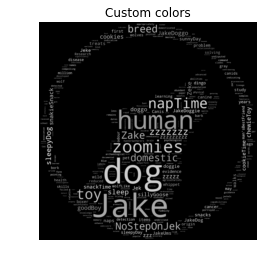

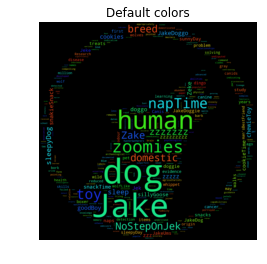

In [45]:
# https://github.com/amueller/word_cloud/tree/master/examples
#!/usr/bin/env python
"""
Using custom colors
===================
Using the recolor method and custom coloring functions.
"""

import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
import random

from wordcloud import WordCloud, STOPWORDS


def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

d = path.dirname(".")

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/star%20wars/storm-trooper.gif
mask = np.array(Image.open(path.join(d, "wild-157677_1280.png")))

# movie script of "a new hope"
# http://www.imsdb.com/scripts/Star-Wars-A-New-Hope.html
# May the lawyers deem this fair use.
text = open("dog_words.txt").read()

wc = WordCloud(max_words=10000, mask=mask, stopwords=stopwords, margin=10,
               random_state=10).generate(text)
# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
wc.to_file("a_new_hope.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()
wc.to_file("a_new_hope.png")